In [1]:
# sample scripts
import pandas as pd
import os
import spacy
from spacy import displacy
import ast
data_dir = os.getcwd()
import nltk
from nltk.tokenize import sent_tokenize
import numpy as np
import matplotlib.pyplot as plt
#print(data_dir)
cohort_df = pd.read_csv(data_dir + '/data/chrtDf.csv')
Pnotes_df = pd.read_pickle('Pnotesfile.pickle')
RadPath_df = pd.read_pickle('RadPathfile.pickle')
SurgPath_df = pd.read_pickle('SurgPathfile.pickle')
cohort_df.rename(columns =  {'tnm_mixed_stage_desc' : 'levels'},inplace= True)
cohort_df = cohort_df.loc[cohort_df['pat_id']!='NOPE']
pat_count = cohort_df.groupby('pat_id').size().sort_values(ascending=False)
# single record seperation
patsWithOne = pat_count.loc[pat_count == 1]
chrtDfOne = cohort_df.loc[cohort_df['pat_id'].isin(list(patsWithOne.index))].reset_index()
#Remove records with no labels or missing labels

chrtDf = chrtDfOne[chrtDfOne.levels != 'Unknown']
chrtDf = chrtDfOne[chrtDfOne.levels != 'Missing']
chrtDf = chrtDfOne[chrtDfOne.levels != 'Not Applicable']
chrtDf = chrtDfOne[chrtDfOne['gender'].notnull()]
chrtDf = chrtDfOne[chrtDfOne['bmi'].notnull()]

#stripping the subclass of cancer staging data; eg. 1A to 1
chrtDf['levels'] = chrtDf['levels'].apply(lambda x: x[0])
#print(text)
nlp = spacy.load("en_core_web_sm")

/home/dbasu/.local/share/virtualenvs/debraj_notebook-uSskSi2b/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Remove rows that have no text or '[ ]'

In [6]:
RadPath_df.dropna(subset=['note_text'], inplace =True)
RadPath_df = RadPath_df[RadPath_df['nlp_text_qu_ner']!='[]']
RadPath_df.reset_index(inplace = True)
RadPath_df.shape
RadPath_df.reset_index(drop = True)
RadPath_df.shape

(14904, 28)

### Using NLTK sentence tokenizer to find out average number of sentences in each note

In [9]:
RadSenLen =[]
for i in RadPath_df.index:
    text =RadPath_df.loc[i]['note_text']
    doc = sent_tokenize(text)
    RadSenLen.append(len(doc))
# for i, token in enumerate(doc):
#     print('-->Sentence %d: %s' % (i, token))
np.mean(np.array(RadSenLen))

17.005233494363928

## Add new columns to RadPath data frame
### Columns: number of sentences in the text, longest and shortest and average number of words in each sentence in the text

In [10]:
RadPath_df =RadPath_df.assign(**{'Number of sentences': np.nan, 'Longest sentence length (words)': np.nan, \
                                 'Shortest sentence length(words)': np.nan, \
                    'average sentence length(words)':np.nan})
# RadPath_df.assign(Number_of_sentences = np.nan, Longest_sentence_length = np.nan, Shortest_sentence_length = np.nan, \
#                    Average_sentence_length= np.nan)

### Add all the sentence lengths in the radpath text notes

In [11]:
def Number_sentence(text):
    return len(sent_tokenize(text))

RadPath_df['Number of sentences'] = RadPath_df['note_text'].apply(Number_sentence)


### Add statistics for each note text

In [12]:
from nltk.tokenize import sent_tokenize, word_tokenize
from statistics import mean
def word_count(doc):
    lenWordHolder =[]
    for i, token in enumerate(doc):
        
        lenWordHolder.append(len(word_tokenize(token)))
    return lenWordHolder
    
def max_length(text):
    doc = sent_tokenize(text)
    len_word = word_count(doc)
    #print(max(len_word))
    return max(len_word)

def min_length(text):
    doc = sent_tokenize(text)
    len_word = word_count(doc)
#     print(min(len_word))
#     print('\n')
#     print(doc)
    return min(len_word)
    
def avg_length(text):
    doc = sent_tokenize(text)
    len_word = word_count(doc)
    return mean(len_word)
        
RadPath_df['Longest sentence length (words)'] = RadPath_df['note_text'].apply(max_length)
RadPath_df['Shortest sentence length(words)'] = RadPath_df['note_text'].apply(min_length)
RadPath_df['average sentence length(words)'] = RadPath_df['note_text'].apply(avg_length)



In [13]:
RadPath_df['note_text'].unique().shape

(12598,)

In [15]:
RadPath_analysis = RadPath_df[['pat_id','result_time','note_text', 'Number of sentences','Longest sentence length (words)',\
                               'Shortest sentence length(words)', 'average sentence length(words)', 'nlp_text_qu_ner' ]]

### Histogram plot

In [ ]:
# RadPath_analysis.hist(column= 'Number of sentences',bins= 50, grid=True, figsize=(12,8), color='red', zorder=2, rwidth=0.9 )
#RadPath_analysis['Number of sentences'].hist(bins =50)
RadPath_analysis['Number of sentences'].value_counts(normalize=True)

### Around 16% of the note texts have only one sentence. We will examine how important are these one-sentence notes for cancer-related information extraction (e.g. stage, grade, anatomical site)

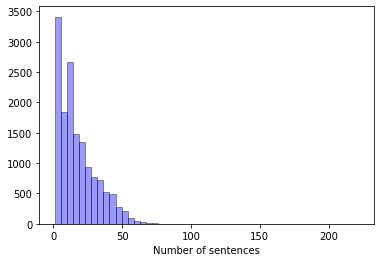

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.distplot(RadPath_analysis['Number of sentences'], hist=True, kde=False, 
             color = 'blue',
             hist_kws={'edgecolor':'black'});

### Converting the note_texts to lower case

In [18]:
RadPath_analysis['note_text'] = RadPath_analysis['note_text'].apply(lambda x: x.lower())

/home/dbasu/.local/share/virtualenvs/debraj_notebook-uSskSi2b/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Size of the record with one sentence : 2413

In [19]:
RadPath_analysis[RadPath_analysis['Number of sentences'] ==1].shape

(2413, 8)

### Unique number of records with size of text equal to one sentence: 746
### Approximately one third are repeated and therefore a high chance that they may not useful (hypothesis)
### We save these unique texts in a text file and will request domain expert intervention to evaluate the importance of those texts.

In [20]:
A = RadPath_analysis[RadPath_analysis['Number of sentences'] ==1]['note_text'].unique()

In [18]:
np.savetxt('RadPath_notes.txt', A, fmt='%s', delimiter=',', newline="\n------------------------------------------------------------\n")

### Check with QUICKUMLS output for any useful concept from these notes containing only one sentence

In [22]:
RadPath_analysis_singleSent = RadPath_analysis[RadPath_analysis['Number of sentences'] ==1]
RadPath_analysis_singleSent =RadPath_analysis_singleSent.assign(**{'T023 output': np.nan, 'T191 output': np.nan})
RadPath_analysis_singleSent.reset_index(inplace= True)


### To check if concept extraction is useful from semstring 

In [23]:
corpus_T023_total = []
corpus_T191_total = []
for i in range(len(RadPath_analysis_singleSent.index)):
    
    text = RadPath_analysis_singleSent.iloc[i].nlp_text_qu_ner
    d = ast.literal_eval(text)
    Testframe = pd.DataFrame.from_dict(d)
    corpus_T023 = Testframe[Testframe['semtypestring'] == 'T023']['ngram'].tolist()
    corpus_T191 = Testframe[Testframe['semtypestring'] == 'T191']['ngram'].tolist()
    corpus_T023_total.append(corpus_T023)
    corpus_T191_total.append(corpus_T191)
    
    

### Most of the outputs are empty
### 94% for T023
### 91% for T191

In [24]:
corpus_T023_total
T023 = [e for e in corpus_T023_total if e]
100*(1- (len(T023)/len(corpus_T023_total)))

T191 = [e for e in corpus_T191_total if e]
100*(1- (len(T191)/len(corpus_T191_total)))

91.42146705346043

In [ ]:
RadPath_analysis_singleSent

### Size of records with 2 sentences : 

In [45]:
RadPath_analysis[RadPath_analysis['Number of sentences'] ==2].shape

(355, 8)

In [39]:
RadPath_analysis[RadPath_analysis['Number of sentences'] ==10]['note_text'].unique().shape

(587,)

In [38]:
data = RadPath_analysis.loc[142]['note_text']
print(data)

prior to biopsy prior to biopsy


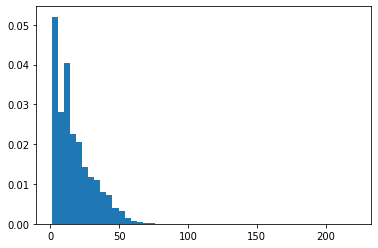

In [181]:
# RadSenLen = np.array(RadSenLen)
plt.hist(RadSenLen, 50, density= True)  # arguments are passed to np.histogram
plt.show()
#plt.title("Histogram with 'auto' bins")

### word2vec model from the words in the sentences
### word vectorization with TFIDF

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_TFIDF = TfidfVectorizer()
vectorizer_CV = CountVectorizer()


In [28]:
text_cohort =[]
for i in range(len(RadPath_analysis_singleSent.index)):
    text = RadPath_analysis_singleSent.loc[i,'note_text']
    text_cohort.append(text)
#     word_input = word_tokenize(text)
    
    
    
#     text_CV= vectorizer_CV.fit_transform(word_input)
#     text_TFIDF = vectorizer_TFIDF.fit_transform(word_input)

### Use TFIDF method to find out the words that has propotional representation in he corpus

In [29]:
text_CV= vectorizer_CV.fit_transform(text_cohort)
text_TFIDF = vectorizer_TFIDF.fit_transform(text_cohort)

In [30]:
vectorizer_CV.get_feature_names()[np.sum(text_CV.toarray(),axis =0).argmax()]
vectorizer_TFIDF.get_feature_names()[np.sum(text_TFIDF.toarray(),axis =0).argmax()]

'test'

In [52]:
np.sum(text_TFIDF.toarray(),axis =0)
#np.sum(text_CV.toarray(),axis =0)
# vectorizer_TFIDF.get_feature_names()[np.sum(text_TFIDF.toarray(),axis =0).argmin()]

array([9.15397012, 0.88261424, 1.24303263, ..., 0.41588321, 0.49862795,
       1.67012404])

### Implement word2vec on th text cohort from the single sentence sets

In [44]:
text_cohort
all_words = [nltk.word_tokenize(sent) for sent in text_cohort]
# Removing Stop Words
from nltk.corpus import stopwords
for i in range(len(all_words)):
    all_words[i] = [w for w in all_words[i] if w not in stopwords.words('english')]

In [40]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(all_words, min_count=5)

In [ ]:
vocabulary = word2vec_model.wv.vocab
print(vocabulary)

In [ ]:
v1 = word2vec_model.wv['test']
v1

In [42]:
f_name = 'wor2vec_model.txt'
word2vec_model.wv.save_word2vec_format(f_name, binary = False)

/home/dbasu/.local/share/virtualenvs/ucd-ri-csnlp-AG0bO8yr/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Implement doc2vec on the sentences

In [ ]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

In [59]:
model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)


V1_infer [-0.01174802  0.01892567  0.02331458 -0.0161646  -0.00370456 -0.00297765
  0.01032512  0.01855865 -0.03251955 -0.01637637  0.00291244  0.01132154
  0.02957965  0.0085325   0.01903096  0.01427311  0.00820519 -0.01913295
  0.01544167  0.00314951]


/home/dbasu/.local/share/virtualenvs/ucd-ri-csnlp-AG0bO8yr/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)

In [47]:
def read_corpus(fname, tokens_only=False):
    with smart_open.smart_open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            if tokens_only:
                yield gensim.utils.simple_preprocess(line)
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

In [48]:
train_corpus = list(read_corpus(lee_train_file))
test_corpus = list(read_corpus(lee_test_file, tokens_only=True))

In [ ]:
train_corpus[:2]

In [50]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)


In [51]:
model.build_vocab(train_corpus)


In [52]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 4.34 s, sys: 135 ms, total: 4.48 s
Wall time: 1.91 s


# Using SpaCy 

In [ ]:
RadSenLen =[]
for i in RadPath_df.index:
    text =RadPath_df.loc[i]['note_text']
    doc = nlp(text)
    RadSenLen.append(len(doc))

In [ ]:
#Return the indices of rows with number of sentences equal to 1
res_list = list(filter(lambda x: RadSenLen[x] == 3, range(len(RadSenLen)))) 

In [ ]:
import random
i = random.choice(res_list)
print(i)
text =RadPath_df.iloc[i]['note_text']
doc = nlp(text)
for i, token in enumerate(doc):
    print('-->Sentence %d: %s' % (i, token))